# Nonisotropic Noise

May 11, 2022

The goal in this notebook is to run a few examples of _non-isotropic noise_ with REINFORCE. How will our flow field metric look? Will the updates follow the true gradient? Or will we have to take into account the covariance structure as well?

From an experimental perspective, I want to understand what the _failure_ modes are.

Approach 1:

* Set $M = \Sigma \cdot (W^{bmi})^\top$, and then slowly change alignment


Approach 2:

* Pretrain a network so that it performs the task proficiently. Then construct a matrix M that consists of the top PCs of the pretrained network activity followed by a linear regression mapping. Compare this matrix with REINFORCE learning that uses noise sampled from the top PCs of the pretrained network.

Although approach 2 seems a little convoluted, I think it represents a possible null hypothesis, a sort of good baseline guess at what might possibly be going on.





I am generating nonisotropic noise in the following manner, in the file `rnn.py`:

```
    def _generate_recurrent_noise(self):

        """ Generate Recurrent Noise from multivariate gaussian

        This function generates noise that is injected into the recurrent units.
        Noise is sampled from a gaussian distribution, and can be nonisotropic or low-D.

        Returns:
        xi: vector of dimension n_rec, divided by square root of integration step dt
        
        Note: It is up to the user to check that a specified covariance matrix is positive semidefinite
        """

        # sample from multivariate gaussian
        mean = np.zeros(self.sig_rec_covariance.shape[0])
            
        xi = self.rng.multivariate_normal(mean, cov=self.sig_rec_covariance, size=1).T # should be size (n_neurons,1)
            
        return xi/np.sqrt(self.dt)
```

In [11]:
folder = 'figures-2022-5-12/'

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [20]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


In [3]:
trial_duration = 20
n_in=4
frac_on = 1

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Proof of Concept - REINFORCE with Nonisotropic noise

Here I construct a particular covariance matrix, and then use it to sample noise for REINFORCE.

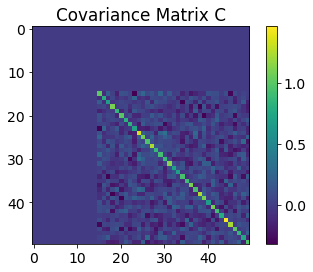

In [13]:
# Example covariance matrix

# construct a positive semidefinite matrix
c = np.random.randn(50,75)/np.sqrt(75) # number of neurons x number of samples
c[0:15] *=0.001
C = c @ c.T


plt.imshow(C)
plt.colorbar()
plt.title('Covariance Matrix C')
plt.show()

6it [00:00, 58.18it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7feb67fc9048>


500it [00:04, 102.63it/s]
5it [00:00, 46.94it/s]

M norm: 1.17	 M angle: 0.41, 9 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.17	 w_out1 vs. w_m angle: 0.41
w_m norm: 1.77	 w_out vs. w_m angle: 0.18
w_out1@C.T norm: 1.73	 w_out1@C.T vs. w_out0 angle: 0.26

1000it [00:13, 73.12it/s]
2000it [00:27, 71.51it/s]
1000it [00:14, 78.23it/s]


AR early fit 0.986, late fit 0.986


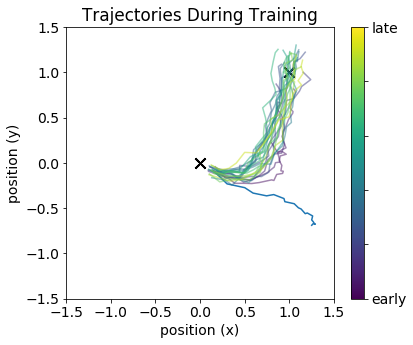

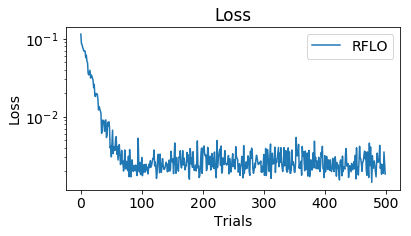

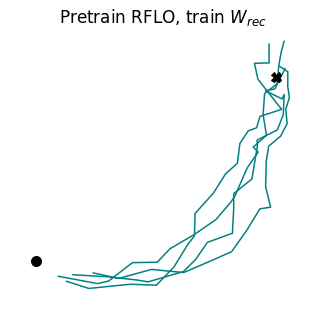

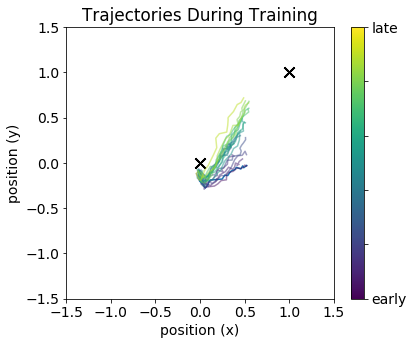

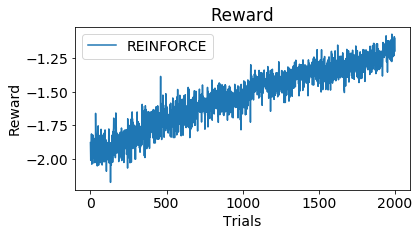

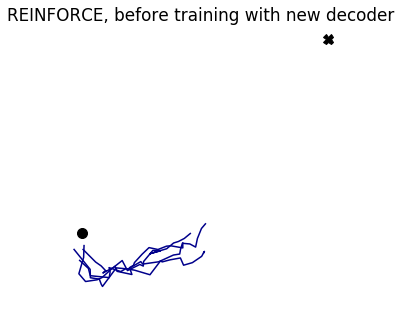

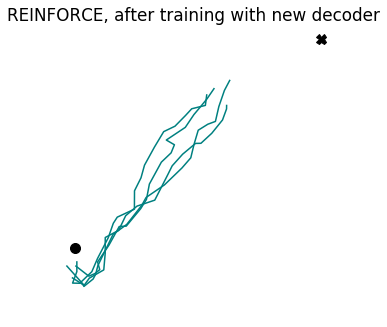

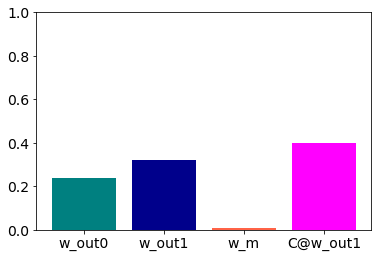

2it [00:00, 16.86it/s]

M norm: 1.20	 M angle: 0.40, 2 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.20	 w_out1 vs. w_m angle: 0.40
w_m norm: 1.63	 w_out vs. w_m angle: 0.34
w_out1@C.T norm: 1.83	 w_out1@C.T vs. w_out0 angle: 0.21

1000it [00:13, 74.47it/s]
2000it [00:28, 69.88it/s]
1000it [00:13, 74.23it/s]


AR early fit 0.986, late fit 0.987


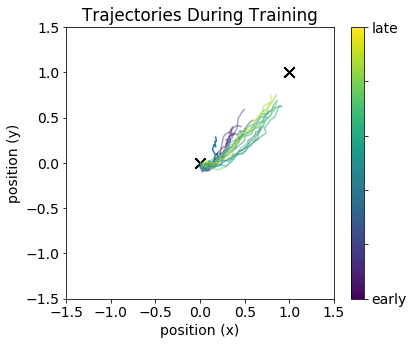

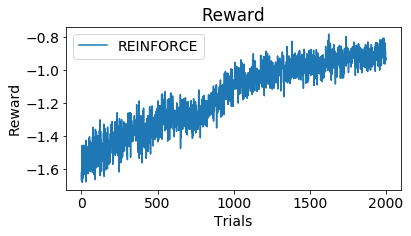

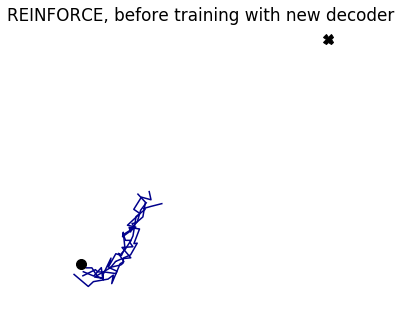

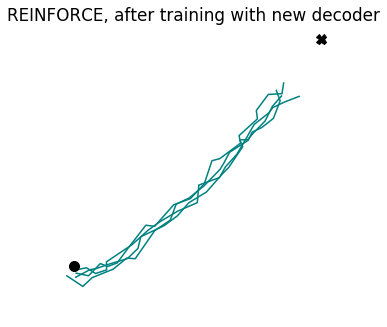

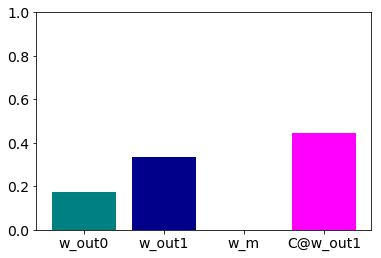

5it [00:00, 46.81it/s]

M norm: 1.16	 M angle: 0.40, 21 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.41
w_m norm: 1.16	 w_out1 vs. w_m angle: 0.40
w_m norm: 1.81	 w_out vs. w_m angle: 0.09
w_out1@C.T norm: 1.72	 w_out1@C.T vs. w_out0 angle: 0.25

1000it [00:13, 74.82it/s]
2000it [00:30, 66.63it/s]
1000it [00:20, 49.59it/s]


AR early fit 0.986, late fit 0.987


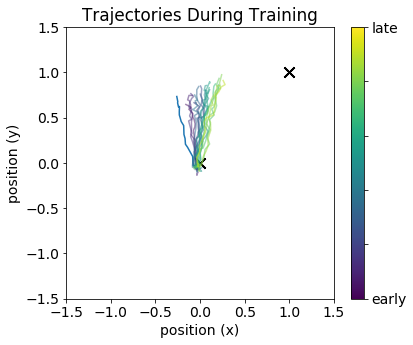

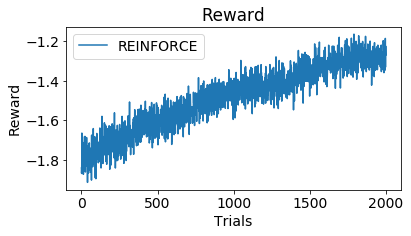

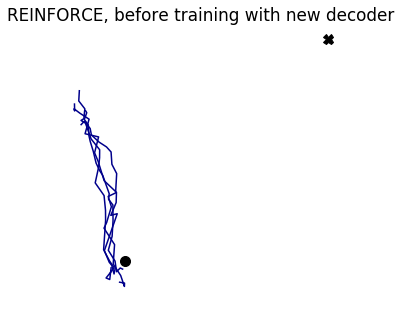

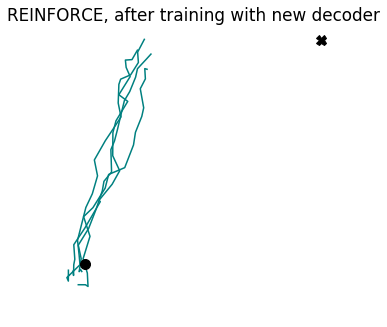

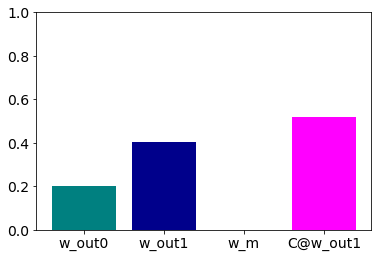

6it [00:00, 49.45it/s]

M norm: 1.15	 M angle: 0.39, 1 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.39
w_m norm: 1.74	 w_out vs. w_m angle: 0.18
w_out1@C.T norm: 1.63	 w_out1@C.T vs. w_out0 angle: 0.31

1000it [00:12, 78.23it/s]
2000it [00:30, 65.84it/s]
1000it [00:12, 77.34it/s]


AR early fit 0.986, late fit 0.987


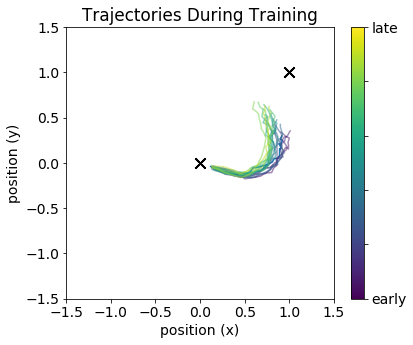

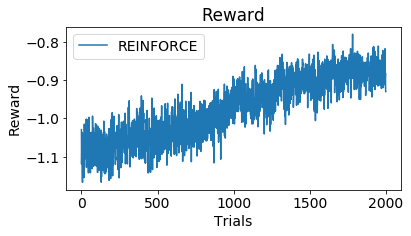

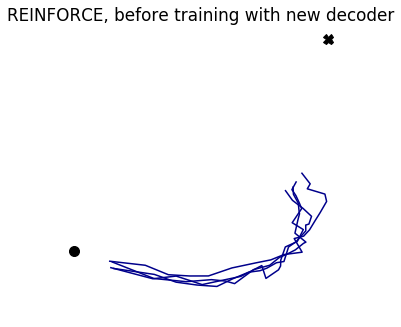

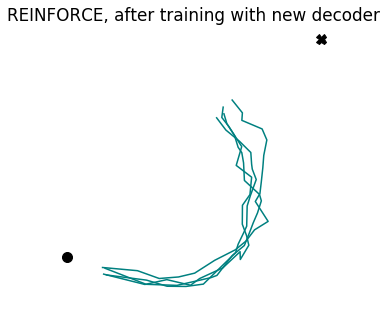

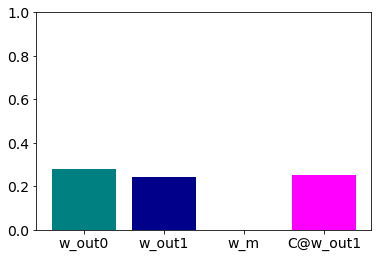

In [5]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN, train with RFLO
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=500, tasks=[task1], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1],title='Pretrain RFLO, train '+r'$W_{rec}$')



""" Average over multiple seeds """
seeds = [1,2,33,44] #,1,12,54,72,81]
overlaps = [0.4]
n_changes = [60]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = [] # for nonisotropic noise
stats['corrcoef'] = []


for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        # confirm overlap between C@w_out1 and w_out
        norm, angle = return_norm_and_angle(w_out1 @ C.T,net0.w_out)
        print('\nw_out1@C.T norm: {:.2f}'.format(norm) + '\t w_out1@C.T vs. w_out0 angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net2_pre = RNN(params,sig_rec_covariance=C)
        net2_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2_pre.set_weights(w_out = w_out1)
        net2_pre.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net2 = RNN(params,sig_rec_covariance=C)
        net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2.set_weights(w_out = w_out1)
        net2.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE



        """ Track activity with new decoder, before training """

        sim2_pre = Simulation(net2_pre)
        trackvars = TrackVars(net2_pre,apply_to=[]) 
        sim2_pre.run_session(n_trials=1000, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim2_train = Simulation(net2)
        reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False,tau_reward=5)
        sim2_train.run_session(n_trials=2000, tasks=[task1], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=100)

        """ Track activity with new decoder, after training """
        net2_post = RNN(params,sig_rec_covariance=C)
        net2_post.set_weights(w_in=net2.w_in.copy(), w_rec=net2.w_rec.copy())
        net2_post.set_weights(w_out = net2.w_out)
        net2_post.set_weights(w_m = 0*net2.w_m) # shouldn't matter for REINFORCE

        sim2_post = Simulation(net2_post)
        trackvars = TrackVars(net2_post,apply_to=[]) 
        sim2_post.run_session(n_trials=1000, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim2_pre, tasks=[task1],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim2_post, tasks=[task1],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim2_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim2_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim2_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim2_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim2_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        Fpred_cov_w_out1 = flow_field_predicted(w_out1@C.T,err_train,h_train) # nonisotropic noise, wout1 is tranposed inside function

        h_test = np.asarray(sim2_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_cov_w_out1,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,3],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m','C@w_out1'],color=['teal','darkblue','tomato','magenta'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)


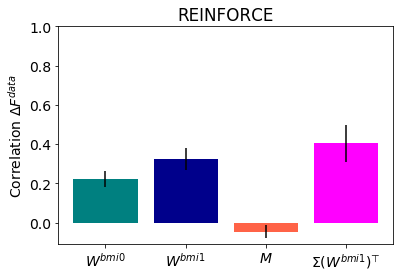

In [6]:
paper = False
save = False

""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
mn4 = np.mean(np.asarray(stats['corr4']),axis=0)[0]
std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]
std4 = np.std(np.asarray(stats['corr4']),axis=0)[0]

fig,ax = plt.subplots(1,1)
plt.bar([0,1,2,3],[mn1,mn2,mn3,mn4],yerr=[std1,std2,std3,std4],tick_label=[r'$W^{bmi0}$',r'$W^{bmi1}$',r'$M$',r'$\Sigma (W^{bmi1})^\top$'],color=['teal','darkblue','tomato','magenta'])

plt.title('REINFORCE')
plt.ylabel('Correlation '+r'$\Delta F^{data}$')
#plt.xlabel('Predicted '+r'$\Delta F$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=None,ticksize=10,linewidth=2,ylim=[0,0.6],figsize=(2,2.25))

    

plt.show()

if save:
    fig.savefig(folder+'reinforce-dF-correlation-nonisotropic.pdf')

As expected, a change in flow field predicted by $\Sigma (W^{bmi})^\top$ does slightly better than a change in flow field predicted by $(W^{bmi})^\top$

# Approach 2 - REINFORCE with PC Covariance from Pretraining

1. Pretrain a network so that it performs the task proficiently. 
2. Then construct a matrix M that consists of the top PCs of the pretrained network activity followed by a linear regression mapping. 
3. Compare this matrix with REINFORCE learning that uses noise sampled from the top PCs of the pretrained network.


When I do this, it $\Sigma (W^{bmi})^\top$ does slightly better than a change in flow field predicted by either $(W^{bmi})^\top$ or $M$. This is good to see.

Note that this result depends on the circuit actually learning for a significant amount of time.




1it [00:00,  7.43it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7ff94a6f2ea0>


500it [00:07, 64.49it/s]


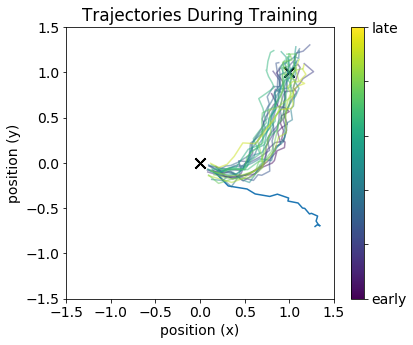

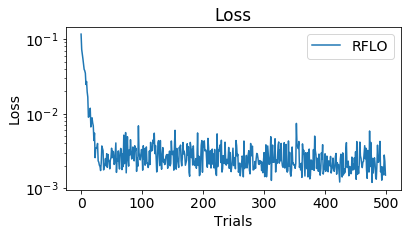

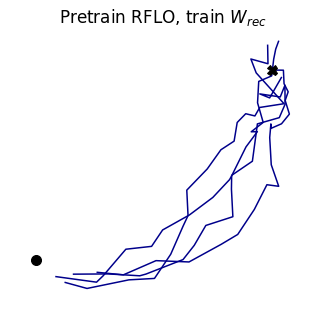

In [8]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN, train with RFLO
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=500, tasks=[task1], learn_alg=[rflo], probe_types=['loss','h','pos'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1],title='Pretrain RFLO, train '+r'$W_{rec}$')


(20, 50)
n_samples,n_features:  (10000, 50)
C:  (10, 50)


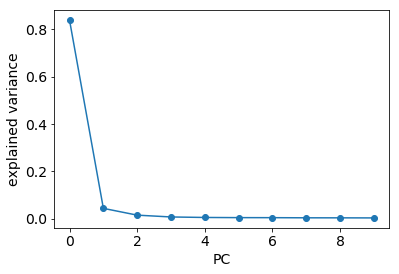

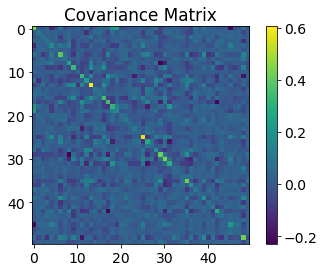

(20, 2)
(10000, 2)
(2, 10)


In [9]:
""" Apply PCA """

# concatenate data
activity = sim0.session_probes['h'][0].squeeze()
print(activity.shape)

for i in range(1,len(sim0.session_probes['h'])):
    activity = np.vstack((activity,sim0.session_probes['h'][i].squeeze()))
    
print('n_samples,n_features: ',activity.shape)

""" Do PCA """

pca = PCA(n_components=10)
pca.fit(activity)
C = pca.components_
covariance = C.T @ C # alternatively, sample noise covariance from activity

print('C: ',pca.components_.shape)
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.show()

plt.imshow(covariance)
plt.colorbar()
plt.title('Covariance Matrix')
plt.show()


""" Compare with cursor location """
pos = sim0.session_probes['pos'][0].squeeze()
print(pos.shape)

for i in range(1,len(sim0.session_probes['pos'])):
    pos = np.vstack((pos,sim0.session_probes['pos'][i].squeeze()))
print(pos.shape)

lr = LinearRegression(fit_intercept=False)
lr.fit((C @ activity.T).T, pos)
D = lr.coef_

print(D.shape)

In [ ]:
pos = D @ C @ activity

C.T @ C @ Wbmi

6it [00:00, 55.62it/s]

M norm: 1.61	 M angle: 0.39, 116 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.29	 w_out1 vs. w_m angle: 0.21
w_m norm: 1.44	 w_out vs. w_m angle: 0.50
w_out1@C.T norm: 1.63	 w_out1@covariance.T vs. w_out0 angle: 0.23

1000it [00:10, 99.61it/s]
5000it [00:55, 90.47it/s]
1000it [00:09, 105.07it/s]


AR early fit 0.956, late fit 0.971


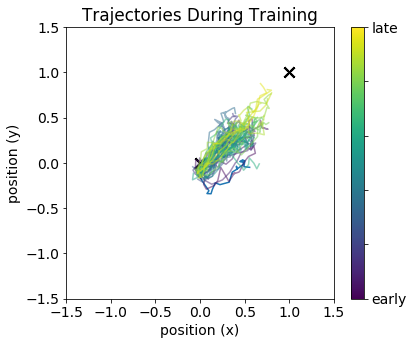

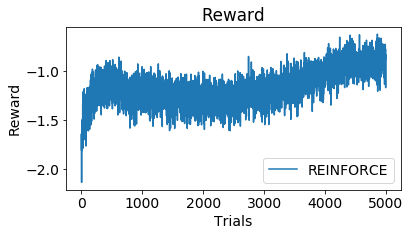

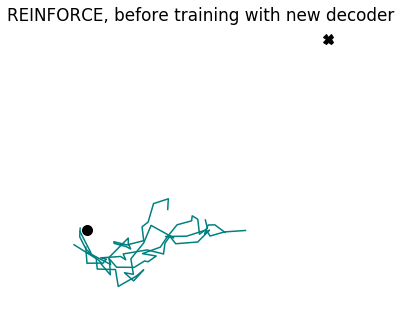

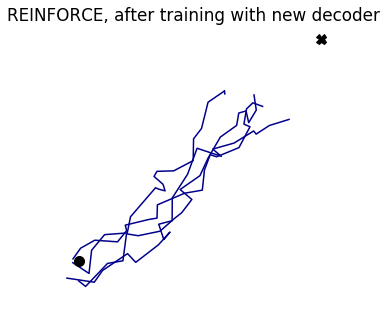

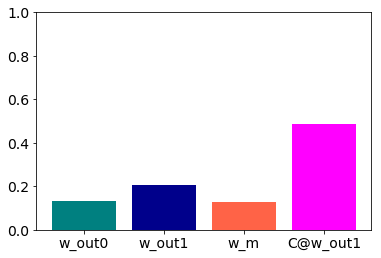

6it [00:00, 53.18it/s]

M norm: 1.61	 M angle: 0.39, 119 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.31	 w_out1 vs. w_m angle: 0.19
w_m norm: 1.44	 w_out vs. w_m angle: 0.50
w_out1@C.T norm: 1.62	 w_out1@covariance.T vs. w_out0 angle: 0.24

1000it [00:11, 89.01it/s]
5000it [00:56, 89.06it/s]
1000it [00:09, 103.42it/s]


AR early fit 0.956, late fit 0.966


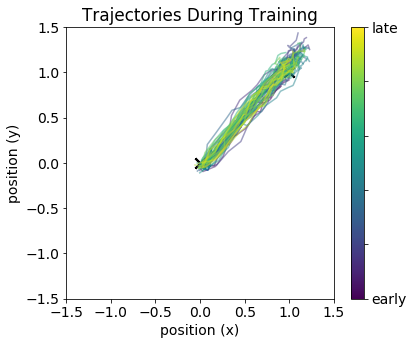

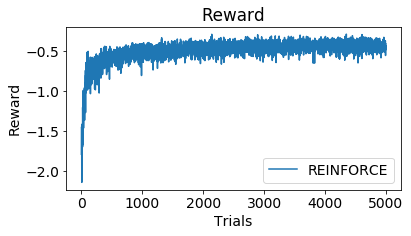

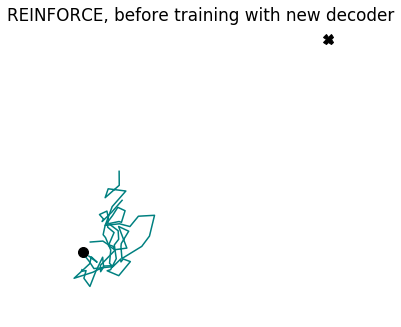

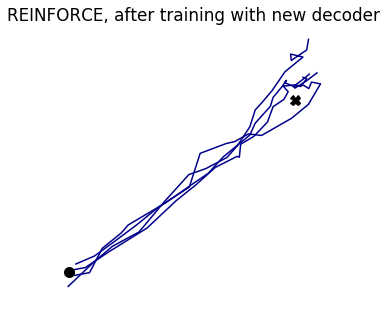

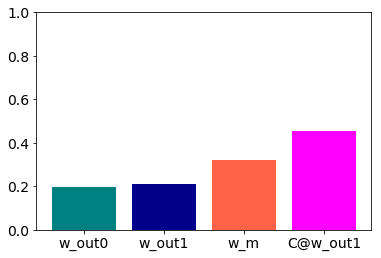

6it [00:00, 54.27it/s]

M norm: 1.61	 M angle: 0.41, 143 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.41
w_m norm: 1.23	 w_out1 vs. w_m angle: 0.30
w_m norm: 1.44	 w_out vs. w_m angle: 0.50
w_out1@C.T norm: 1.61	 w_out1@covariance.T vs. w_out0 angle: 0.28

1000it [00:10, 82.54it/s]
5000it [00:56, 88.54it/s]
1000it [00:09, 103.44it/s]


AR early fit 0.956, late fit 0.969


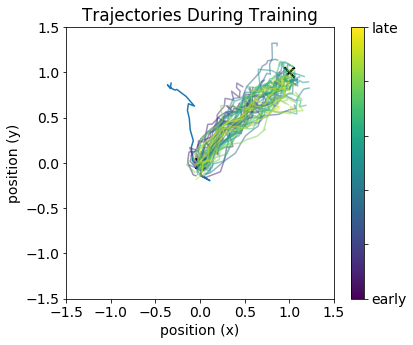

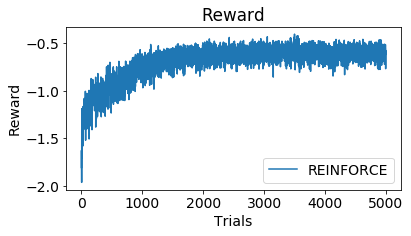

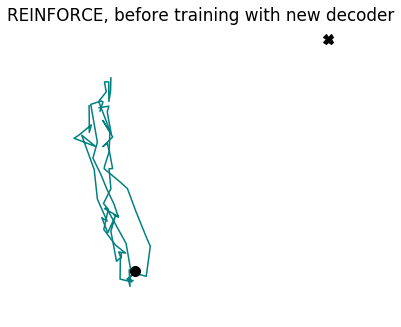

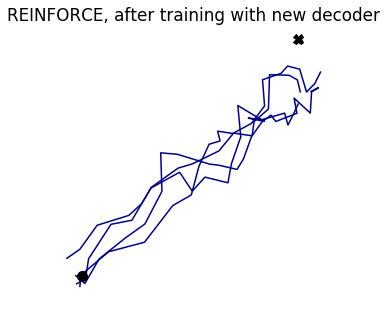

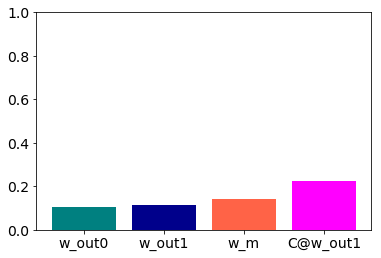

5it [00:00, 49.99it/s]

M norm: 1.60	 M angle: 0.40, 157 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.24	 w_out1 vs. w_m angle: 0.25
w_m norm: 1.44	 w_out vs. w_m angle: 0.50
w_out1@C.T norm: 1.62	 w_out1@covariance.T vs. w_out0 angle: 0.25

1000it [00:09, 105.23it/s]
5000it [00:56, 88.07it/s]
1000it [00:09, 102.38it/s]


AR early fit 0.956, late fit 0.968


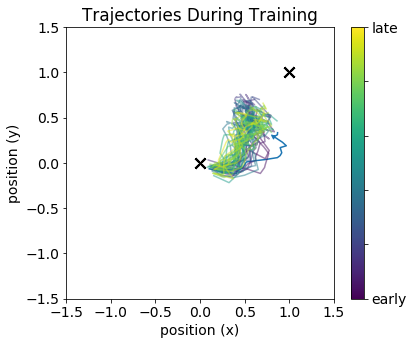

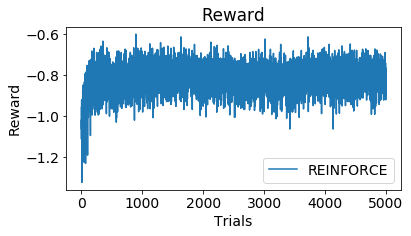

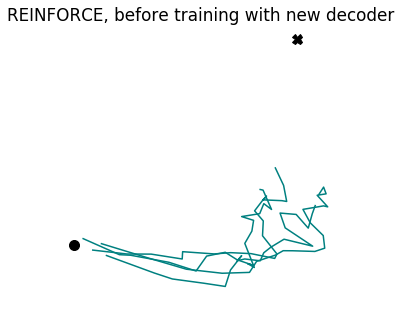

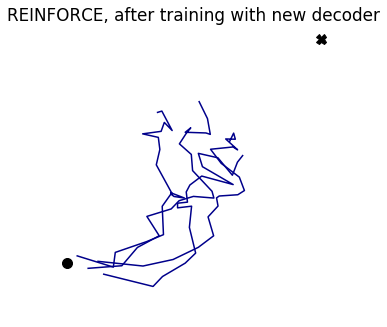

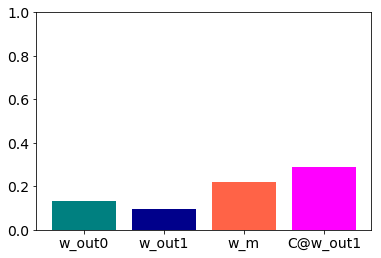

In [10]:
""" Set Models """
w_m=(D@C) # using PCA on pretrained network

""" Average over multiple seeds """
seeds = [1,2,33,44] #,1,12,54,72,81]
overlaps = [0.4]
n_changes = [60]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = [] # for nonisotropic noise
stats['corrcoef'] = []


for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        #w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        # confirm overlap between C@w_out1 and w_out
        norm, angle = return_norm_and_angle(w_out1 @ covariance.T,net0.w_out)
        print('\nw_out1@C.T norm: {:.2f}'.format(norm) + '\t w_out1@covariance.T vs. w_out0 angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net2_pre = RNN(params,sig_rec_covariance=covariance)
        net2_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2_pre.set_weights(w_out = w_out1)
        net2_pre.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net2 = RNN(params,sig_rec_covariance=covariance)
        net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2.set_weights(w_out = w_out1)
        net2.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE



        """ Track activity with new decoder, before training """

        sim2_pre = Simulation(net2_pre)
        trackvars = TrackVars(net2_pre,apply_to=[]) 
        sim2_pre.run_session(n_trials=1000, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim2_train = Simulation(net2)
        reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False,tau_reward=5)
        sim2_train.run_session(n_trials=5000, tasks=[task1], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=100)

        """ Track activity with new decoder, after training """
        net2_post = RNN(params,sig_rec_covariance=covariance)
        net2_post.set_weights(w_in=net2.w_in.copy(), w_rec=net2.w_rec.copy())
        net2_post.set_weights(w_out = net2.w_out)
        net2_post.set_weights(w_m = 0*net2.w_m) # shouldn't matter for REINFORCE

        sim2_post = Simulation(net2_post)
        trackvars = TrackVars(net2_post,apply_to=[]) 
        sim2_post.run_session(n_trials=1000, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim2_pre, tasks=[task1],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim2_post, tasks=[task1],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim2_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim2_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim2_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim2_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim2_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        Fpred_cov_w_out1 = flow_field_predicted(w_out1@covariance.T,err_train,h_train) # nonisotropic noise, wout1 is tranposed inside function

        h_test = np.asarray(sim2_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_cov_w_out1,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,3],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m','C@w_out1'],color=['teal','darkblue','tomato','magenta'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)


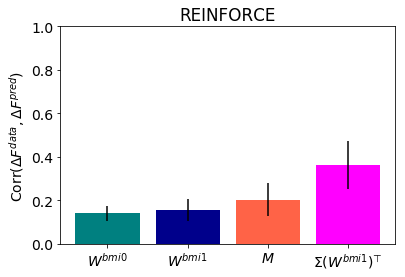

In [11]:
paper = False
save = False

""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
mn4 = np.mean(np.asarray(stats['corr4']),axis=0)[0]
std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]
std4 = np.std(np.asarray(stats['corr4']),axis=0)[0]

fig,ax = plt.subplots(1,1)
plt.bar([0,1,2,3],[mn1,mn2,mn3,mn4],yerr=[std1,std2,std3,std4],tick_label=[r'$W^{bmi0}$',r'$W^{bmi1}$',r'$M$',r'$\Sigma (W^{bmi1})^\top$'],color=['teal','darkblue','tomato','magenta'])

plt.title('REINFORCE')
plt.ylabel('Corr('+r'$\Delta F^{data},$'+r'$\Delta F^{pred})$')
#plt.xlabel('Predicted '+r'$\Delta F$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=None,ticksize=10,linewidth=2,ylim=[0,0.6],figsize=(2,2.25))

    

plt.show()

if save:
    fig.savefig(folder+'reinforce-dF-correlation-nonisotropic-pca.pdf')

# Approach 1 - Set $M = \Sigma$, and vary the alignment between them

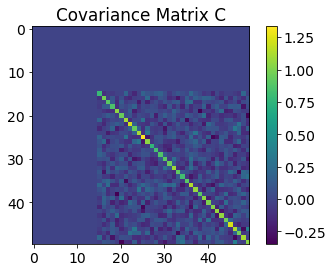

In [4]:
# Example covariance matrix

# construct a positive semidefinite matrix
c = np.random.randn(50,75)/np.sqrt(75) # number of neurons x number of samples
c[0:15] *=0.001
covariance = c @ c.T


plt.imshow(covariance)
plt.colorbar()
plt.title('Covariance Matrix C')
plt.show()

3it [00:00, 29.55it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f830af2b558>


2500it [00:29, 103.84it/s]


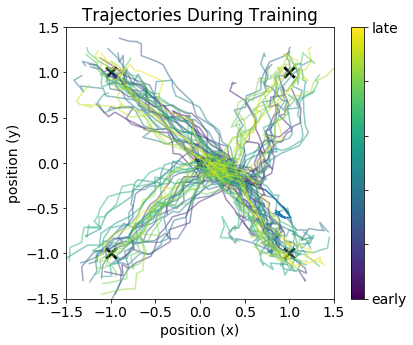

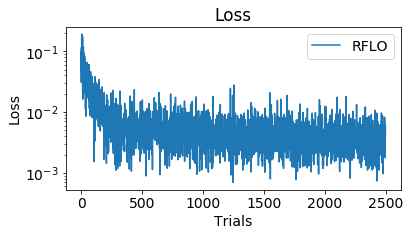

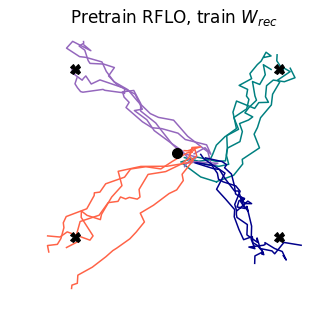

In [5]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN, train with RFLO
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')


6it [00:00, 58.39it/s]

M norm: 1.21	 M angle: 0.20, 7 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.35	 w_out1 vs. w_m angle: 0.09
w_m norm: 1.79	 w_out vs. w_m angle: 0.10
w_out1@C.T norm: 1.62	 w_out1@covariance.T vs. w_out0 angle: 0.36

1000it [00:14, 66.89it/s]
10000it [02:21, 70.56it/s]
1000it [00:12, 78.10it/s]


AR early fit 0.942, late fit 0.959


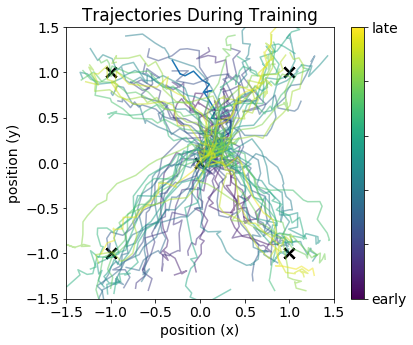

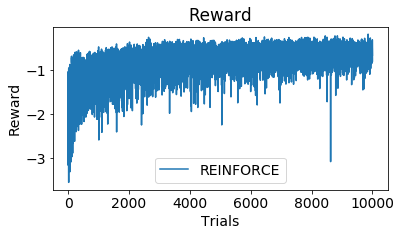

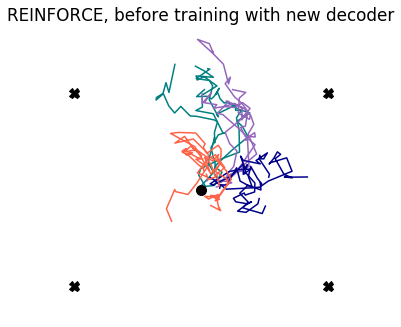

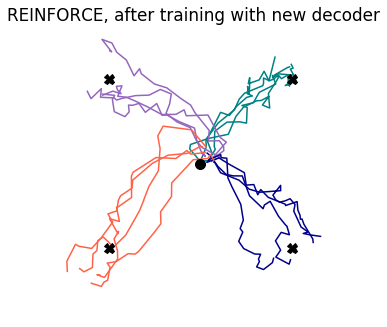

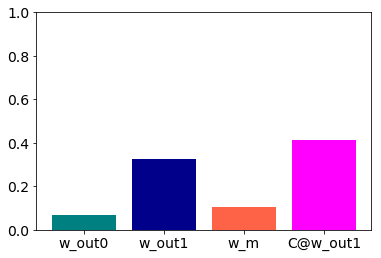

7it [00:00, 61.22it/s]

M norm: 1.06	 M angle: 0.40, 3 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.23	 w_out1 vs. w_m angle: 0.25
w_m norm: 1.86	 w_out vs. w_m angle: 0.01
w_out1@C.T norm: 1.62	 w_out1@covariance.T vs. w_out0 angle: 0.36

1000it [00:12, 77.90it/s]
10000it [02:16, 73.03it/s]
1000it [00:13, 75.52it/s]


AR early fit 0.942, late fit 0.959


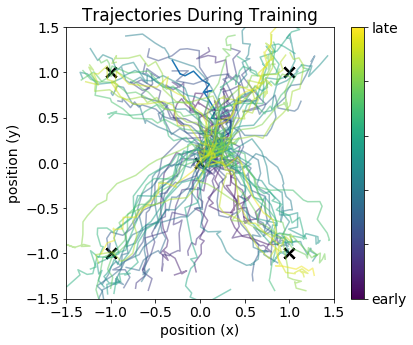

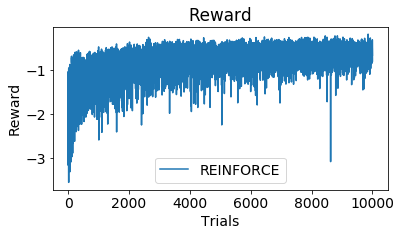

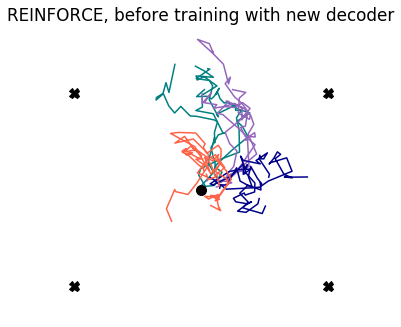

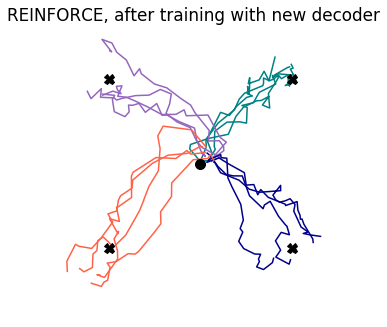

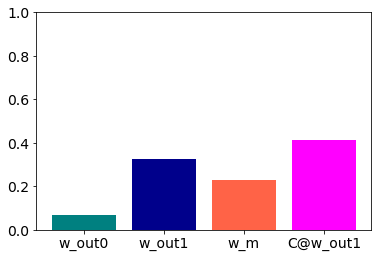

8it [00:00, 72.10it/s]

M norm: 0.91	 M angle: 0.60, 7 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.07	 w_out1 vs. w_m angle: 0.49
w_m norm: 1.76	 w_out vs. w_m angle: 0.18
w_out1@C.T norm: 1.62	 w_out1@covariance.T vs. w_out0 angle: 0.36

1000it [00:12, 78.47it/s]
10000it [02:21, 70.44it/s]
1000it [00:12, 77.69it/s]


AR early fit 0.942, late fit 0.959


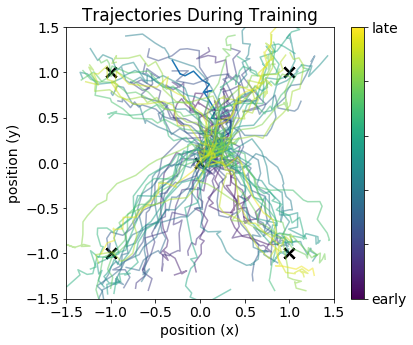

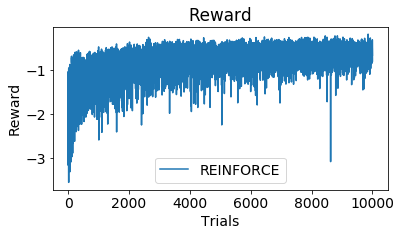

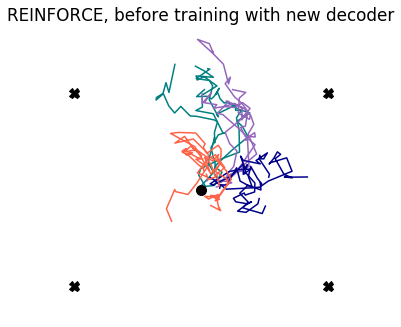

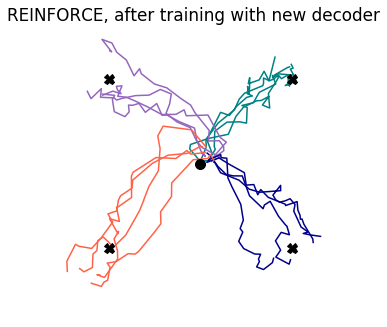

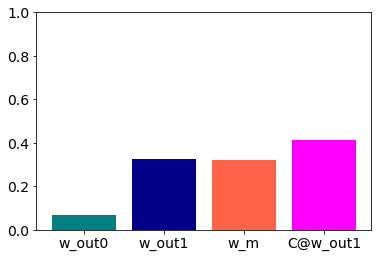

6it [00:00, 53.71it/s]

M norm: 0.64	 M angle: 0.80, 8 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 0.96	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.27
w_out1@C.T norm: 1.62	 w_out1@covariance.T vs. w_out0 angle: 0.36

1000it [00:12, 77.05it/s]
10000it [02:21, 70.55it/s]
1000it [00:13, 75.93it/s]


AR early fit 0.942, late fit 0.959


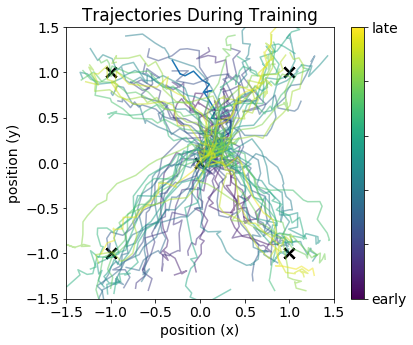

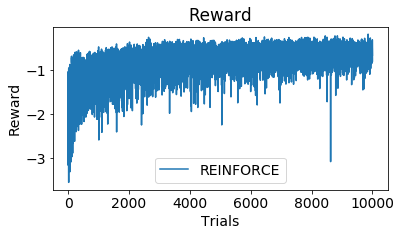

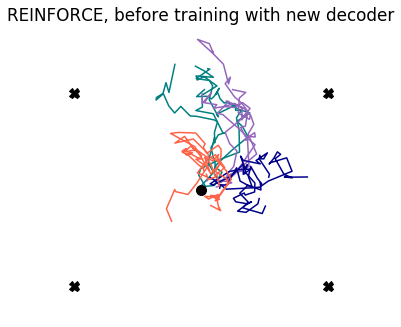

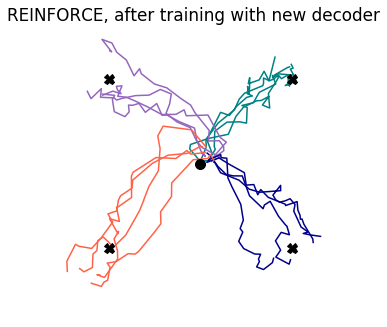

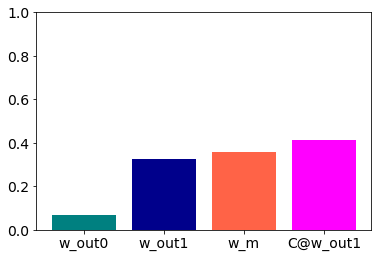

7it [00:00, 67.22it/s]

M norm: 0.00	 M angle: 1.00, 0 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 0.84	 w_out1 vs. w_m angle: 0.71
w_m norm: 1.62	 w_out vs. w_m angle: 0.36
w_out1@C.T norm: 1.62	 w_out1@covariance.T vs. w_out0 angle: 0.36

1000it [00:12, 67.61it/s]
10000it [02:32, 65.69it/s]
1000it [00:13, 75.78it/s]


AR early fit 0.942, late fit 0.959


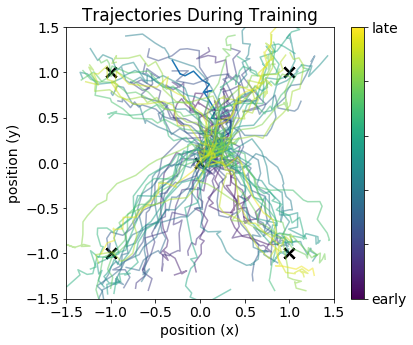

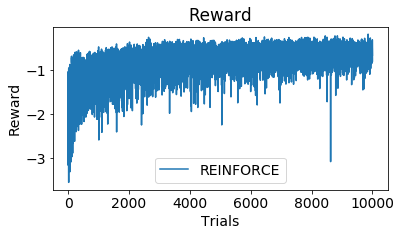

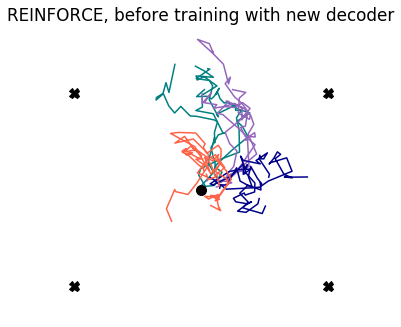

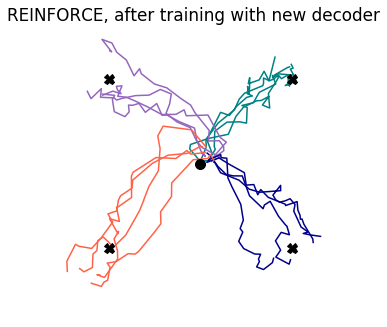

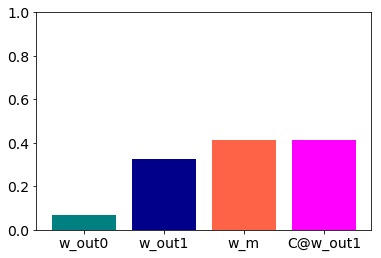

8it [00:00, 74.94it/s]

M norm: 1.41	 M angle: 0.20, 19 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.36	 w_out1 vs. w_m angle: 0.16
w_m norm: 1.73	 w_out vs. w_m angle: 0.20
w_out1@C.T norm: 1.59	 w_out1@covariance.T vs. w_out0 angle: 0.44

1000it [00:14, 67.45it/s]
10000it [02:20, 71.28it/s]
1000it [00:12, 80.38it/s]


AR early fit 0.942, late fit 0.966


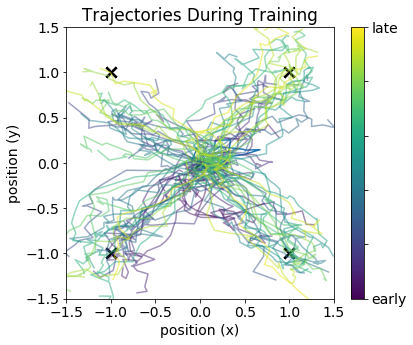

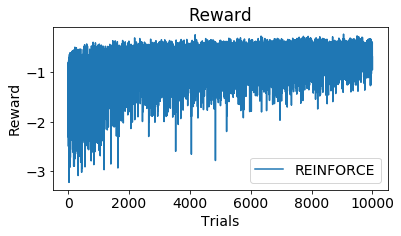

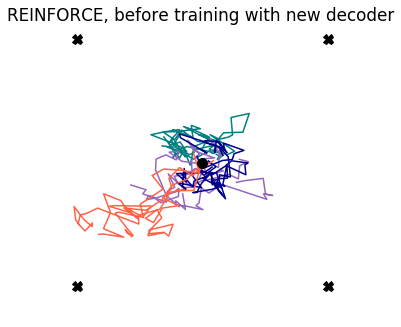

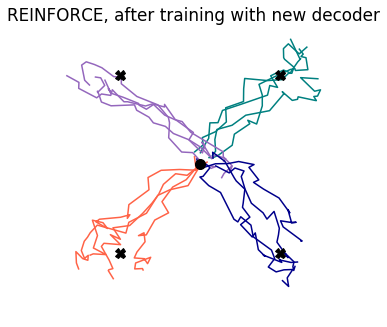

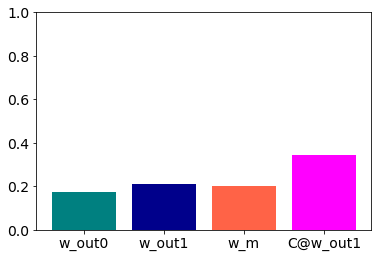

5it [00:00, 49.58it/s]

M norm: 1.27	 M angle: 0.41, 54 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.35	 w_out1 vs. w_m angle: 0.24
w_m norm: 1.77	 w_out vs. w_m angle: 0.20
w_out1@C.T norm: 1.59	 w_out1@covariance.T vs. w_out0 angle: 0.44

1000it [00:13, 76.53it/s]
10000it [02:18, 72.11it/s]
1000it [00:12, 82.84it/s]


AR early fit 0.942, late fit 0.966


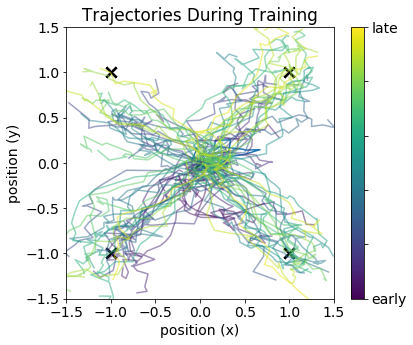

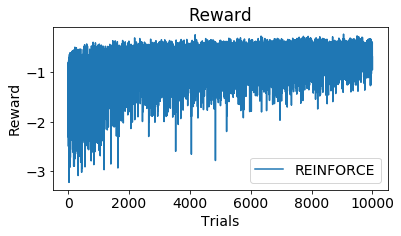

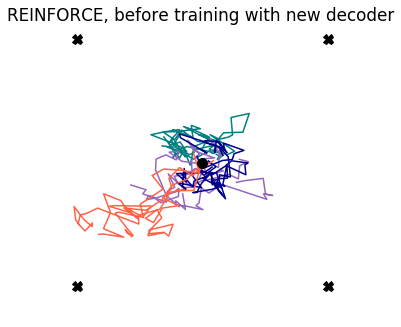

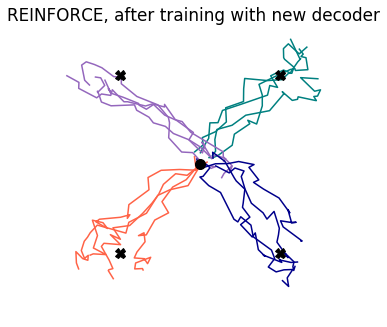

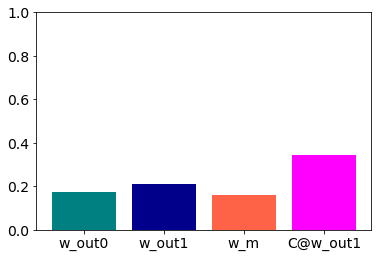

6it [00:00, 57.44it/s]

M norm: 1.08	 M angle: 0.59, 15 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.21	 w_out1 vs. w_m angle: 0.42
w_m norm: 1.78	 w_out vs. w_m angle: 0.20
w_out1@C.T norm: 1.59	 w_out1@covariance.T vs. w_out0 angle: 0.44

1000it [00:13, 73.95it/s]
10000it [02:28, 67.17it/s]
1000it [00:12, 77.99it/s]


AR early fit 0.942, late fit 0.966


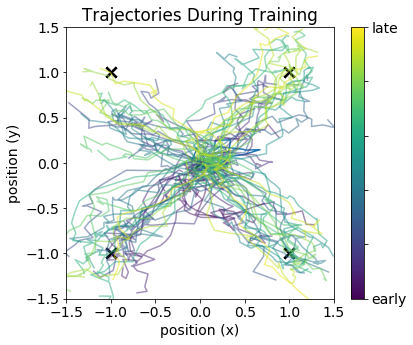

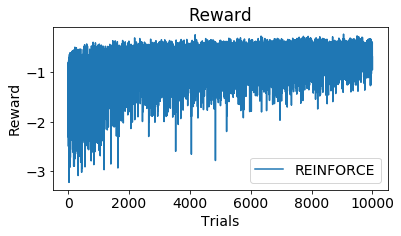

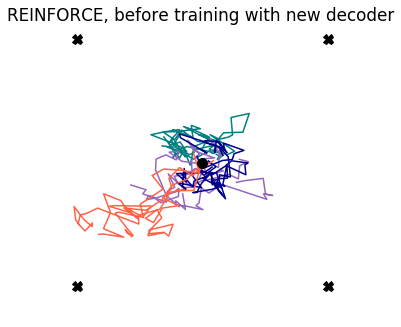

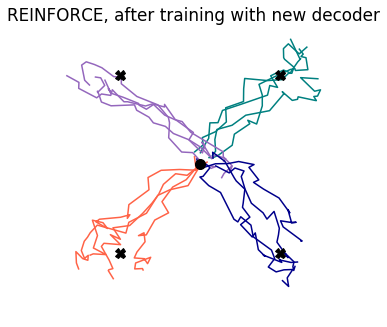

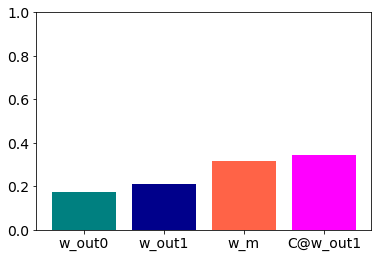

7it [00:00, 68.68it/s]

M norm: 0.77	 M angle: 0.80, 11 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.03	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.59	 w_out vs. w_m angle: 0.41
w_out1@C.T norm: 1.59	 w_out1@covariance.T vs. w_out0 angle: 0.44

1000it [00:12, 77.27it/s]
10000it [02:29, 66.83it/s]
1000it [00:12, 83.04it/s]


AR early fit 0.942, late fit 0.966


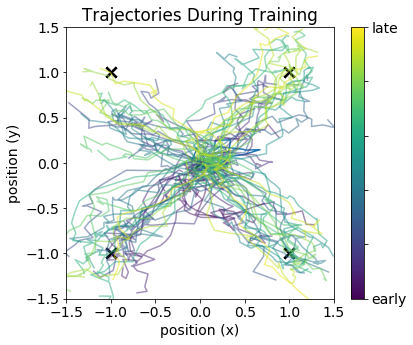

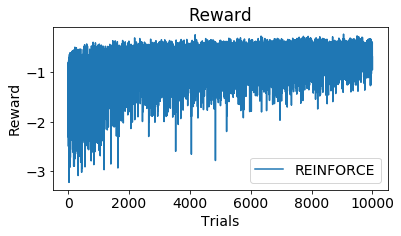

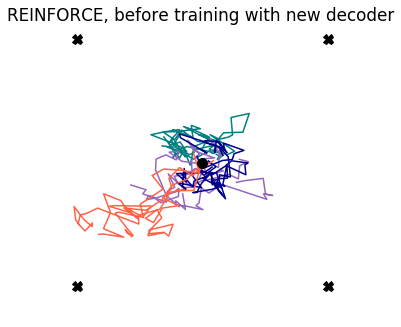

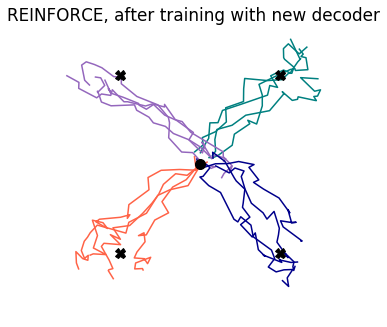

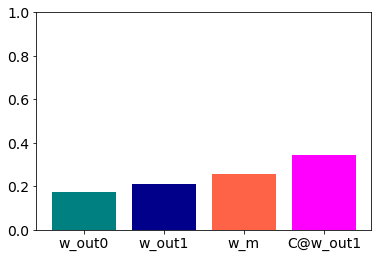

7it [00:00, 69.61it/s]

M norm: 0.00	 M angle: 1.00, 0 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 0.97	 w_out1 vs. w_m angle: 0.70
w_m norm: 1.59	 w_out vs. w_m angle: 0.44
w_out1@C.T norm: 1.59	 w_out1@covariance.T vs. w_out0 angle: 0.44

1000it [00:15, 64.60it/s]
10000it [02:19, 71.69it/s]
1000it [00:12, 81.92it/s]


AR early fit 0.942, late fit 0.966


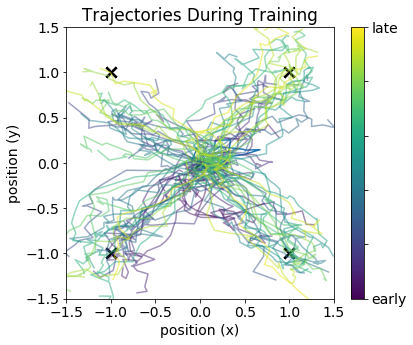

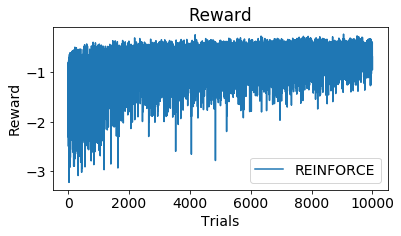

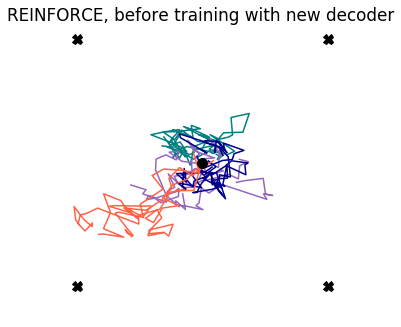

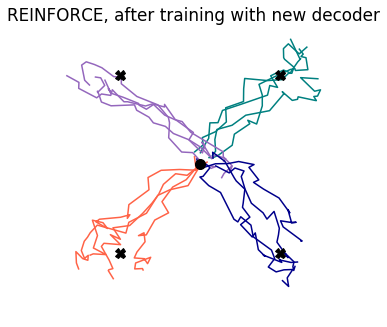

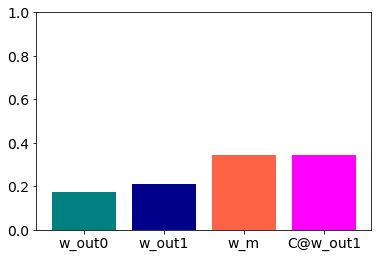

8it [00:00, 73.79it/s]

M norm: 1.47	 M angle: 0.20, 20 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.39	 w_out1 vs. w_m angle: 0.17
w_m norm: 1.72	 w_out vs. w_m angle: 0.25
w_out1@C.T norm: 1.71	 w_out1@covariance.T vs. w_out0 angle: 0.35

1000it [00:12, 82.97it/s]
10000it [02:42, 61.62it/s]
1000it [00:12, 80.32it/s]


AR early fit 0.942, late fit 0.963


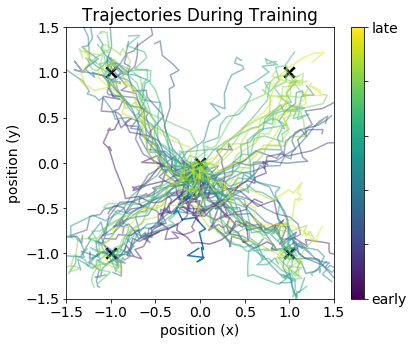

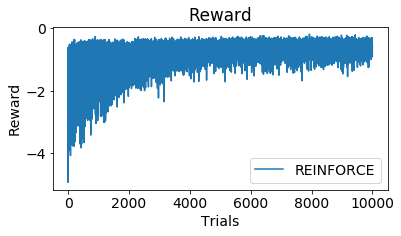

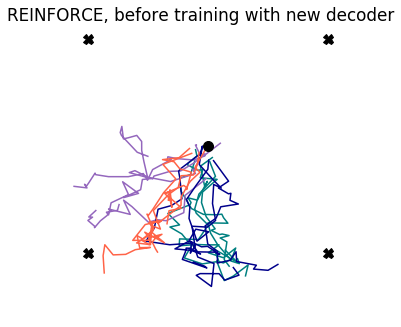

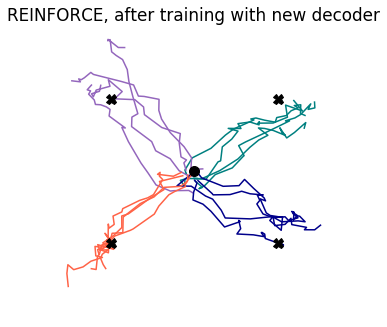

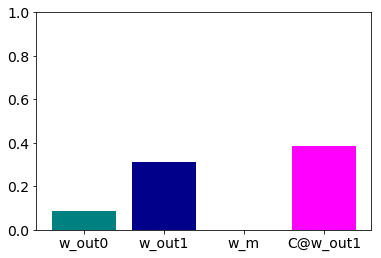

7it [00:00, 68.90it/s]

M norm: 1.25	 M angle: 0.40, 37 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.18	 w_out1 vs. w_m angle: 0.37
w_m norm: 1.78	 w_out vs. w_m angle: 0.16
w_out1@C.T norm: 1.71	 w_out1@covariance.T vs. w_out0 angle: 0.35

1000it [00:14, 71.15it/s]
10000it [02:24, 69.06it/s]
1000it [00:12, 82.05it/s]


AR early fit 0.942, late fit 0.963


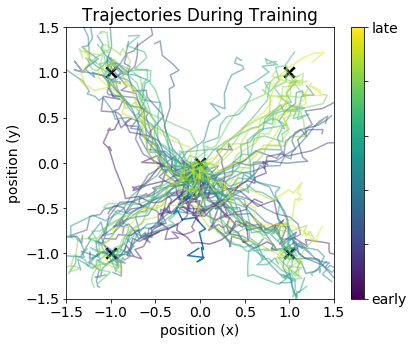

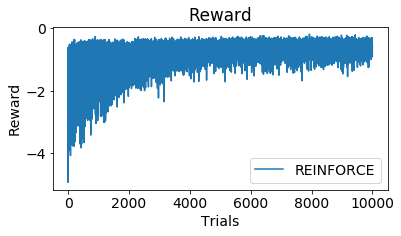

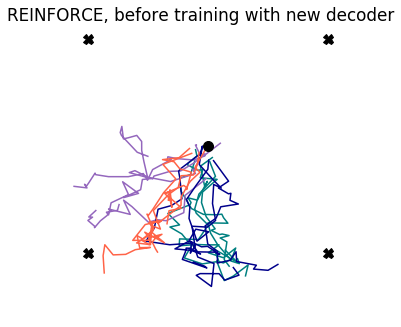

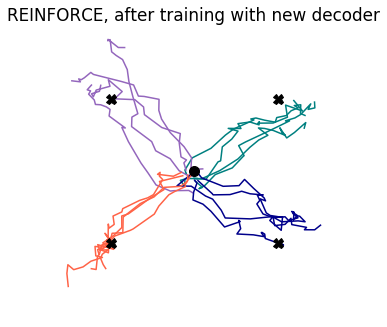

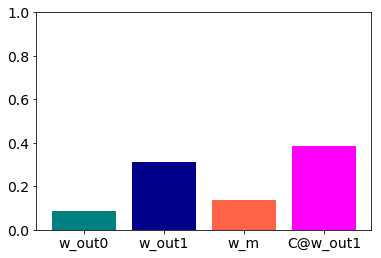

8it [00:00, 72.01it/s]

M norm: 1.08	 M angle: 0.60, 39 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.22	 w_out1 vs. w_m angle: 0.40
w_m norm: 1.68	 w_out vs. w_m angle: 0.32
w_out1@C.T norm: 1.71	 w_out1@covariance.T vs. w_out0 angle: 0.35

1000it [00:12, 79.04it/s]
10000it [02:21, 70.49it/s]
1000it [00:12, 82.49it/s]


AR early fit 0.942, late fit 0.963


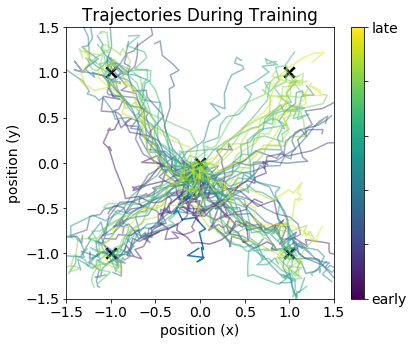

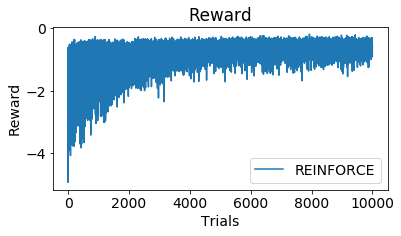

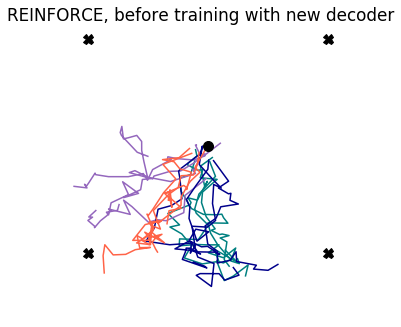

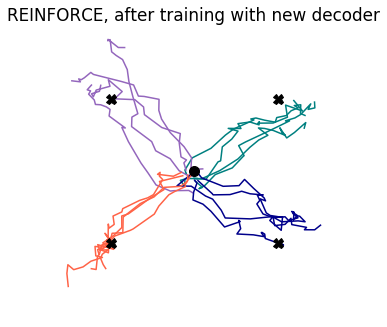

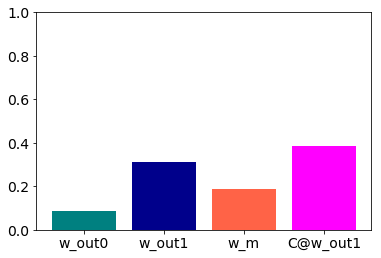

8it [00:00, 77.13it/s]

M norm: 0.80	 M angle: 0.79, 8 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.54
w_m norm: 1.69	 w_out vs. w_m angle: 0.32
w_out1@C.T norm: 1.71	 w_out1@covariance.T vs. w_out0 angle: 0.35

1000it [00:13, 71.84it/s]
10000it [02:22, 70.28it/s]
1000it [00:13, 72.34it/s]


AR early fit 0.942, late fit 0.963


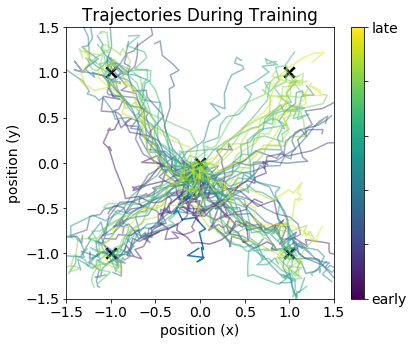

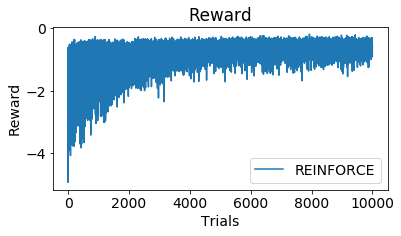

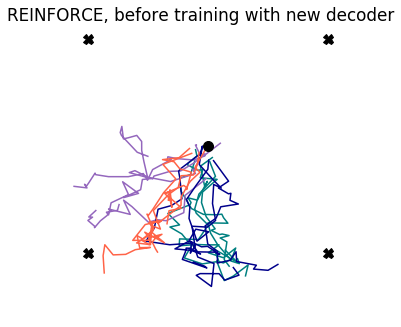

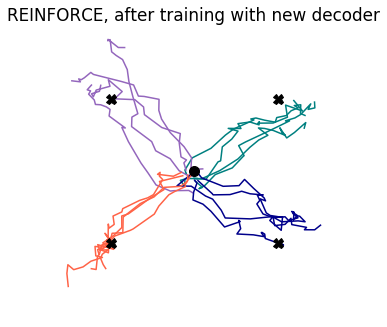

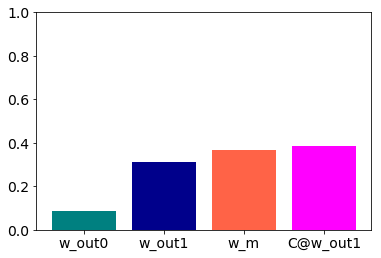

7it [00:00, 62.35it/s]

M norm: 0.00	 M angle: 1.00, 0 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 0.95	 w_out1 vs. w_m angle: 0.70
w_m norm: 1.71	 w_out vs. w_m angle: 0.35
w_out1@C.T norm: 1.71	 w_out1@covariance.T vs. w_out0 angle: 0.35

1000it [00:13, 71.68it/s]
10000it [02:35, 64.17it/s]
1000it [00:12, 78.50it/s]


AR early fit 0.942, late fit 0.963


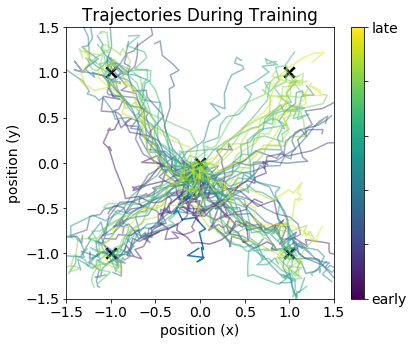

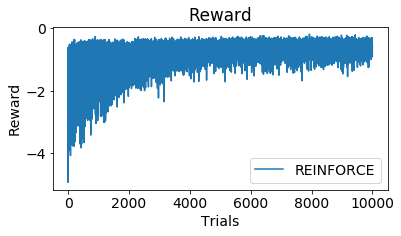

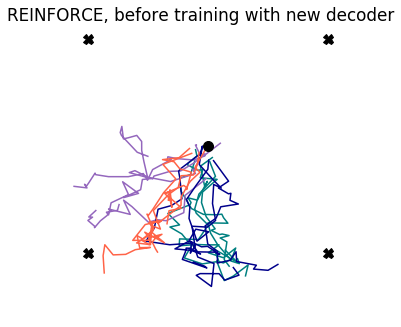

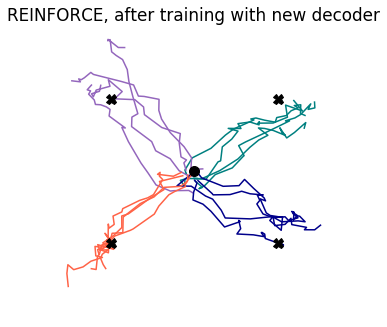

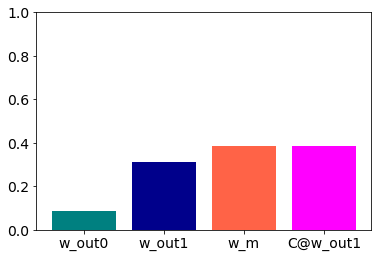

8it [00:00, 74.23it/s]

M norm: 1.43	 M angle: 0.20, 10 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.35	 w_out1 vs. w_m angle: 0.17
w_m norm: 1.86	 w_out vs. w_m angle: 0.05
w_out1@C.T norm: 1.82	 w_out1@covariance.T vs. w_out0 angle: 0.27

1000it [00:13, 73.92it/s]
10000it [02:22, 70.14it/s]
1000it [00:12, 80.78it/s]


AR early fit 0.942, late fit 0.958


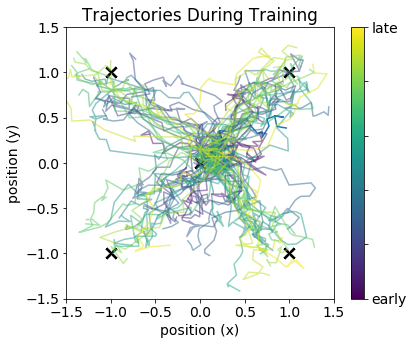

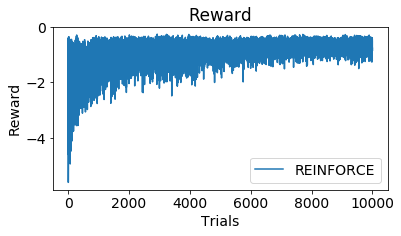

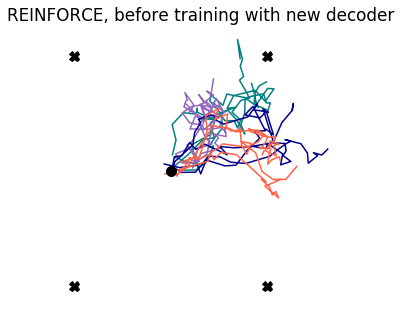

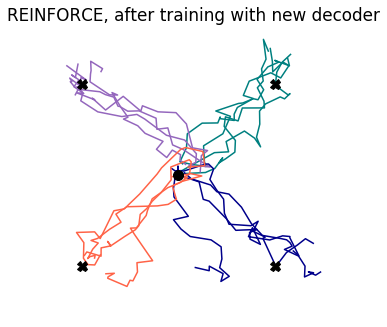

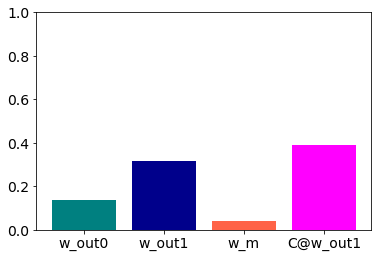

6it [00:00, 56.81it/s]

M norm: 1.28	 M angle: 0.41, 8 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.39	 w_out1 vs. w_m angle: 0.18
w_m norm: 1.87	 w_out vs. w_m angle: 0.09
w_out1@C.T norm: 1.82	 w_out1@covariance.T vs. w_out0 angle: 0.27

1000it [00:14, 67.79it/s]
10000it [02:23, 69.57it/s]
1000it [00:14, 69.28it/s]


AR early fit 0.942, late fit 0.958


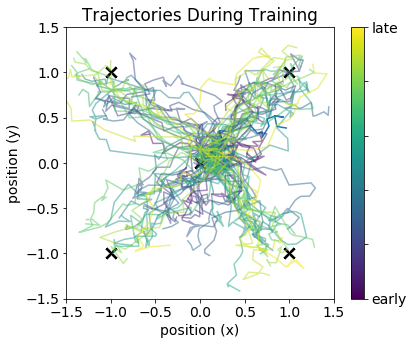

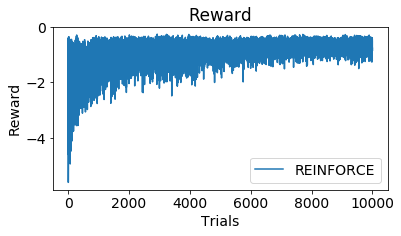

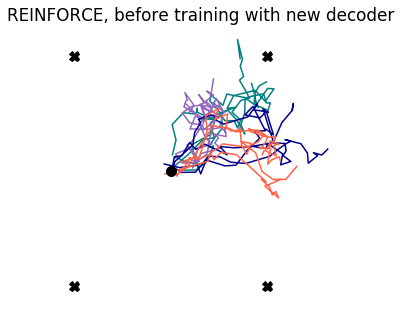

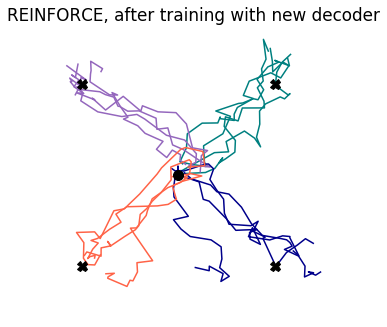

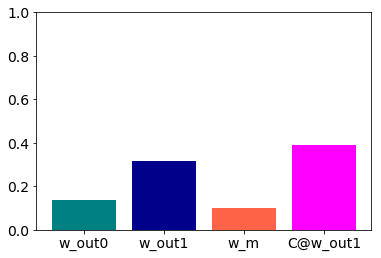

8it [00:00, 74.72it/s]

M norm: 1.08	 M angle: 0.61, 2 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.33	 w_out1 vs. w_m angle: 0.31
w_m norm: 1.96	 w_out vs. w_m angle: 0.05
w_out1@C.T norm: 1.82	 w_out1@covariance.T vs. w_out0 angle: 0.27

1000it [00:13, 72.98it/s]
10000it [02:23, 69.82it/s]
1000it [00:12, 78.66it/s]


AR early fit 0.942, late fit 0.958


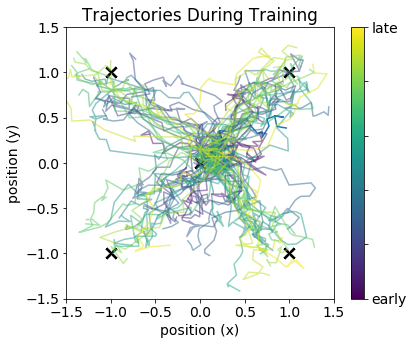

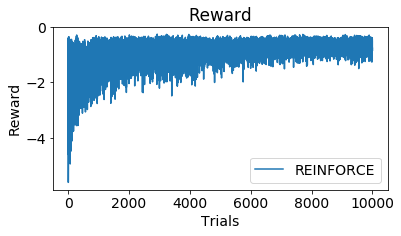

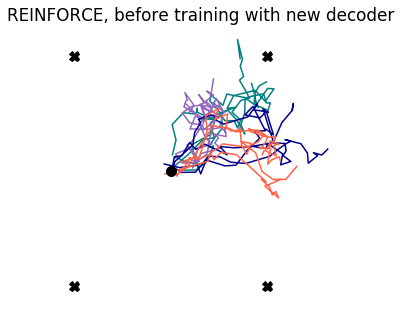

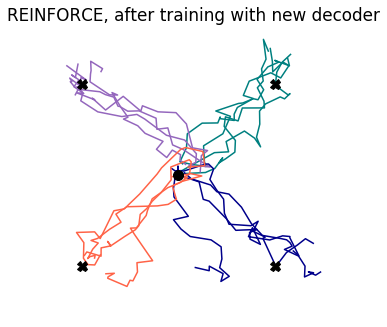

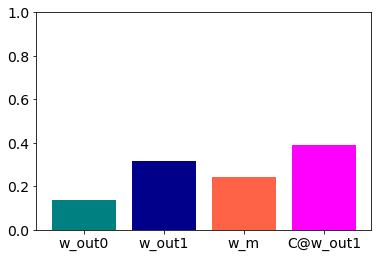

6it [00:00, 59.35it/s]

M norm: 0.78	 M angle: 0.80, 8 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.10	 w_out1 vs. w_m angle: 0.55
w_m norm: 1.91	 w_out vs. w_m angle: 0.12
w_out1@C.T norm: 1.82	 w_out1@covariance.T vs. w_out0 angle: 0.27

1000it [00:17, 56.03it/s]
10000it [02:22, 70.33it/s]
1000it [00:11, 83.94it/s]


AR early fit 0.942, late fit 0.958


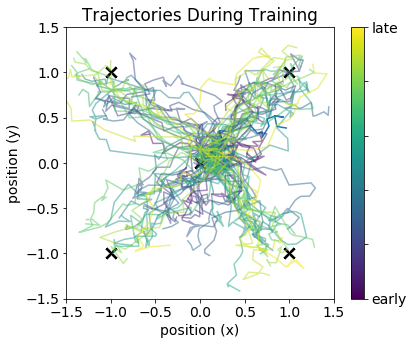

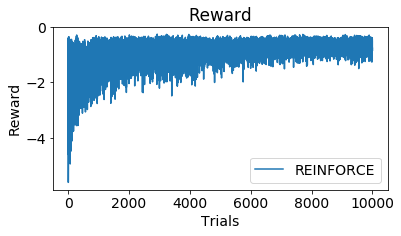

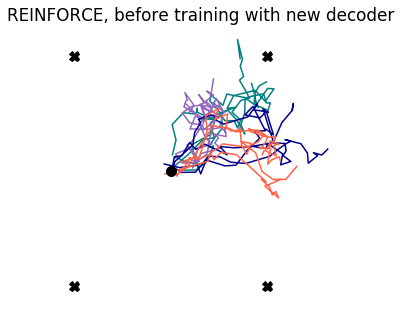

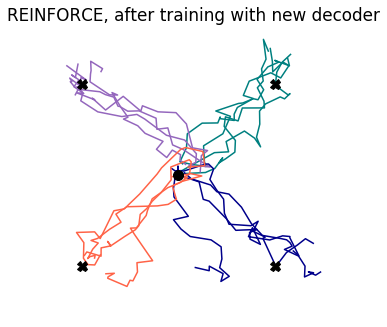

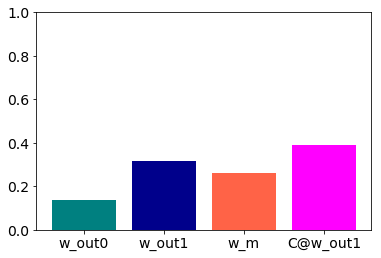

8it [00:00, 75.34it/s]

M norm: 0.00	 M angle: 1.00, 0 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 0.91	 w_out1 vs. w_m angle: 0.73
w_m norm: 1.82	 w_out vs. w_m angle: 0.27
w_out1@C.T norm: 1.82	 w_out1@covariance.T vs. w_out0 angle: 0.27

1000it [00:14, 69.77it/s]
10000it [02:23, 69.62it/s]
1000it [00:12, 82.30it/s]


AR early fit 0.942, late fit 0.958


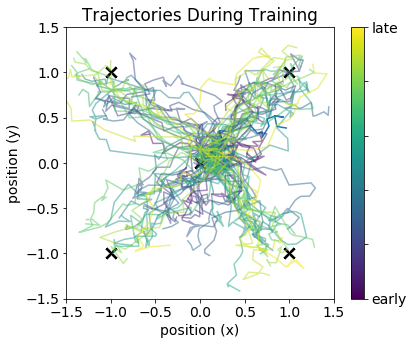

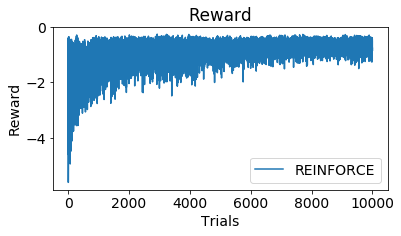

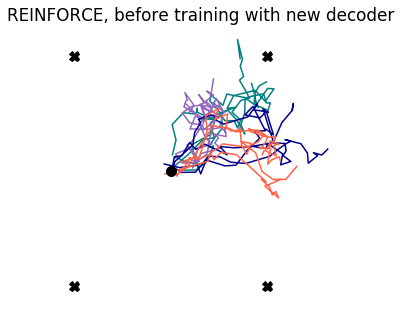

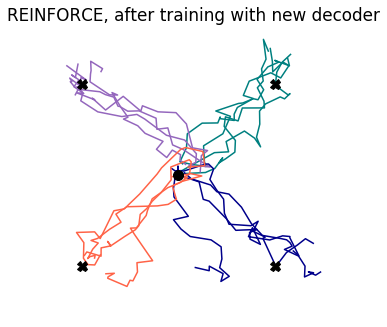

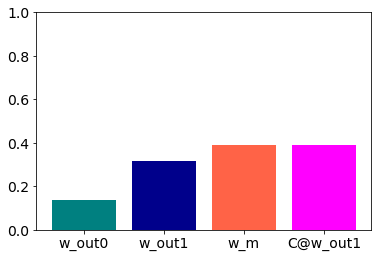

In [8]:
""" Set Models """

""" Average over multiple seeds """
seeds = [22,23,24,26] #[1,22,33,44] #,2,33,44] #,1,12,54,72,81]
overlaps = [0.2,0.4,0.6,0.8,1]
n_changes = [80,60,40,20,0]

overlap_w_out0 = 0.4
n_changes_w_out0 = 60

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = [] # for nonisotropic noise
stats['corrcoef'] = []


for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_changes_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        """ set M \angle covariance @ w_out.T """
        w_m = choose_aligned_matrix(w_out1 @ covariance.T,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        # confirm overlap between C@w_out1 and w_out
        norm, angle = return_norm_and_angle(w_out1 @ covariance.T,net0.w_out)
        print('\nw_out1@C.T norm: {:.2f}'.format(norm) + '\t w_out1@covariance.T vs. w_out0 angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net2_pre = RNN(params,sig_rec_covariance=covariance)
        net2_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2_pre.set_weights(w_out = w_out1)
        net2_pre.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net2 = RNN(params,sig_rec_covariance=covariance)
        net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2.set_weights(w_out = w_out1)
        net2.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE



        """ Track activity with new decoder, before training """

        sim2_pre = Simulation(net2_pre)
        trackvars = TrackVars(net2_pre,apply_to=[]) 
        sim2_pre.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim2_train = Simulation(net2)
        reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False,tau_reward=5)
        sim2_train.run_session(n_trials=10000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=100)

        """ Track activity with new decoder, after training """
        net2_post = RNN(params,sig_rec_covariance=covariance)
        net2_post.set_weights(w_in=net2.w_in.copy(), w_rec=net2.w_rec.copy())
        net2_post.set_weights(w_out = net2.w_out)
        net2_post.set_weights(w_m = 0*net2.w_m) # shouldn't matter for REINFORCE

        sim2_post = Simulation(net2_post)
        trackvars = TrackVars(net2_post,apply_to=[]) 
        sim2_post.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim2_pre, tasks=[task1,task2,task3,task4],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim2_post, tasks=[task1,task2,task3,task4],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim2_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim2_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim2_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim2_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim2_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        Fpred_cov_w_out1 = flow_field_predicted(w_out1@covariance.T,err_train,h_train) # nonisotropic noise, wout1 is tranposed inside function

        h_test = np.asarray(sim2_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_cov_w_out1,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,3],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m','C@w_out1'],color=['teal','darkblue','tomato','magenta'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)


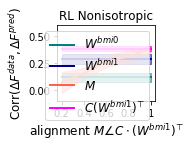

In [31]:
""" Same plot using flow field """
paper = True
save = True


fig,ax = plt.subplots(1,1,figsize=(6,4))

mn1 = np.mean(np.asarray(stats['corr1']),axis=0)
std1 = np.std(np.asarray(stats['corr1']),axis=0)

mn2 = np.mean(np.asarray(stats['corr2']),axis=0)
std2 = np.std(np.asarray(stats['corr2']),axis=0)

mn3 = np.mean(np.asarray(stats['corr3']),axis=0)
std3 = np.std(np.asarray(stats['corr3']),axis=0)

mn4 = np.mean(np.asarray(stats['corr4']),axis=0)
std4 = np.std(np.asarray(stats['corr4']),axis=0)


plt.plot(overlaps,mn1,'-',linewidth=2,label=r'$W^{bmi0}$',color='teal')
plt.fill_between(overlaps,mn1-std1,mn1+std1,alpha=0.5,color='teal')


plt.plot(overlaps,mn2,'-',linewidth=2,label=r'$W^{bmi1}$',color='darkblue')
plt.fill_between(overlaps,mn2-std2,mn2+std2,alpha=0.5,color='darkblue')

plt.plot(overlaps,mn3,'-',linewidth=2,label=r'$ M$',color='tomato')
plt.fill_between(overlaps,mn3-std3,mn3+std3,alpha=0.5,color='tomato')

plt.plot(overlaps,mn4,'-',linewidth=2,label=r'$C (W^{bmi1})^\top$',color='magenta')
plt.fill_between(overlaps,mn4-std4,mn4+std4,alpha=0.5,color='magenta')

plt.ylim([-0.2,1])
plt.legend(loc=2)
plt.title('RL Nonisotropic')
plt.xlabel('alignment '+r'$M \angle C \cdot (W^{bmi1})^\top$')
plt.ylabel('Corr'+r'$(\Delta F^{data}, \Delta F^{pred})$')

plt.tight_layout()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0.2,0.4,0.6,0.8,1],ylabels=None,ticksize=10,linewidth=2,ylim=[-.1,0.6],figsize=(2.25,2.5))

plt.show()

if save:
    if paper:
        fig.savefig(folder+'rflo-dF-change-m-cbmi.pdf')
    else:
        fig.savefig(folder+'rflo-dF-change-m-cbmi_v2.pdf')
